Back-Propagation || bank


**Import modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold
import tensorflow.keras as kr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline


**Loading data**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional.csv to bank-additional.csv
Saving bank-additional-full.csv to bank-additional-full.csv
Saving bank-additional-names.txt to bank-additional-names.txt


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "bank-additional.csv" with length 583898 bytes
User uploaded file "bank-additional-full.csv" with length 5834924 bytes
User uploaded file "bank-additional-names.txt" with length 5458 bytes


In [4]:
# Load training data
filename1 = 'bank-additional.csv'
#filename1 = 'bank-additional-full.csv'
bank_additional = pd.read_csv(filename1, delimiter=';', header=0)

# Create a DataFrame
bank_df = pd.DataFrame(bank_additional)
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [5]:
# Data exploration
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [6]:
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# Explore the prediction target
bank_df['y'].value_counts()

no     3668
yes     451
Name: y, dtype: int64

**Data preprocessing**

In [8]:
# get all categorical columns in the dataframe
catCols = [col for col in bank_df.columns if bank_df[col].dtype=="O"]
print(catCols)

lb_make = LabelEncoder()

for item in catCols:
    bank_df[item] = lb_make.fit_transform(bank_df[item])

bank_df.head()

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,1,1,2,0,2,0,0,6,0,...,2,999,0,1,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,7,2,3,0,0,0,1,6,0,...,4,999,0,1,1.1,93.994,-36.4,4.855,5191.0,0
2,25,7,1,3,0,2,0,1,4,4,...,1,999,0,1,1.4,94.465,-41.8,4.962,5228.1,0
3,38,7,1,2,0,1,1,1,4,0,...,3,999,0,1,1.4,94.465,-41.8,4.959,5228.1,0
4,47,0,1,6,0,2,0,0,7,1,...,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8,0


<Axes: >

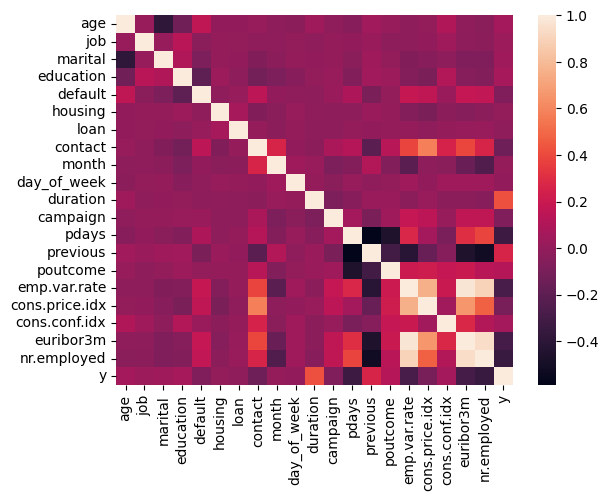

In [9]:
# Check correlation with heatmap graph
corr = bank_df.corr()
sns.heatmap(corr,
xticklabels=corr.columns.values,
yticklabels=corr.columns.values)

In [10]:
from sklearn.model_selection import train_test_split

X = bank_df.drop(['y'],axis=1).values   # independant features
y = bank_df['y'].values					        # dependant variable

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
# Normalize the values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


**Cross validation || using Keras**

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
78/78 [==============================] - 1s 2ms/step - loss: 0.1791 - acc: 0.7964
Epoch 2/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1072 - acc: 0.8919
Epoch 3/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0906 - acc: 0.8932
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0838 - acc: 0.8952
Epoch 5/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0800 - acc: 0.8988
Epoch 6/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0774 - acc: 0.9017
Epoch 7/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0754 - acc: 0.9045
Epoch 8/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0738 - acc: 0.9037
Epoch 9/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0723 - acc: 0.9041
Epoch 10/1000
78/78 [===========================

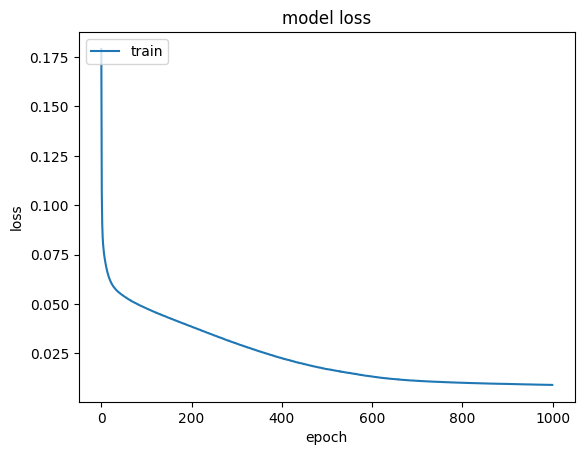

26/26 [==============================] - 0s 2ms/step


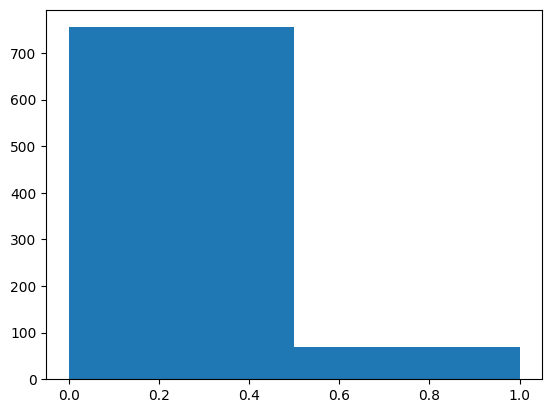

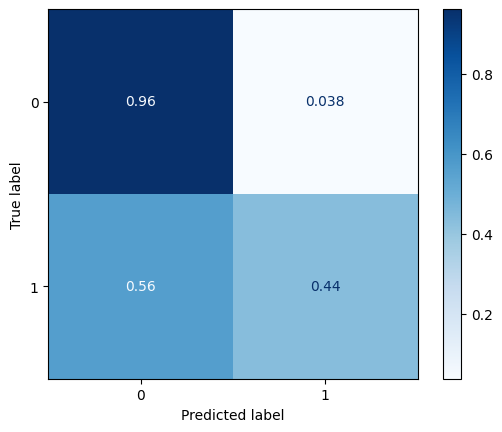

Confusion matrix:
 [[702  28]
 [ 53  41]]
Percentage classification error obtained from validation set: 9.83009708737864%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000
78/78 [==============================] - 1s 2ms/step - loss: 0.2031 - acc: 0.8329
Epoch 2/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1498 - acc: 0.8907
Epoch 3/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1211 - acc: 0.8907
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1069 - acc: 0.8907
Epoch 5/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.0988 - acc: 0.8907
Epoch 6/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.0932 - acc: 0.8907
Epoch 7/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.0892 - acc: 0.8907
Epoch 8/1000
78/78 [==============================] - 0s 3ms/step - loss: 0.0863 - acc: 0.8907
Epoch 9/1000
78/78 [=

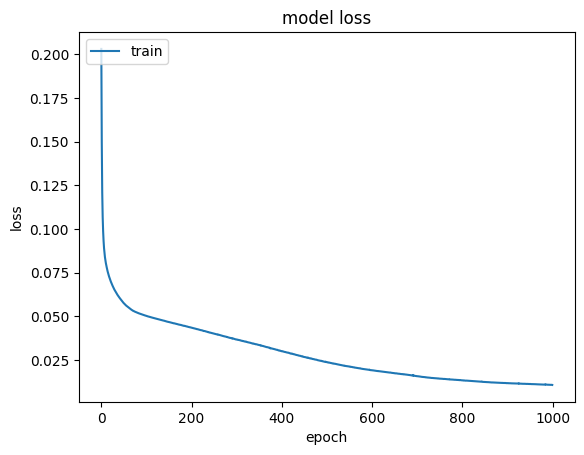

26/26 [==============================] - 0s 2ms/step


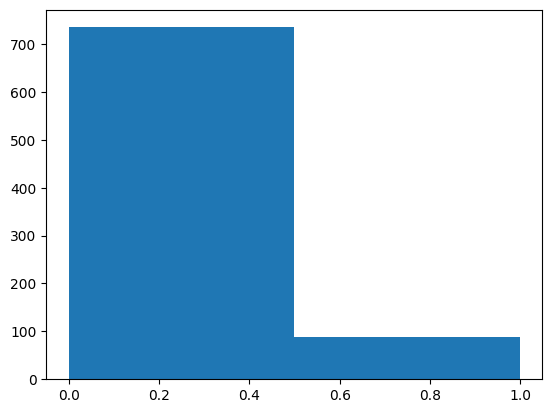

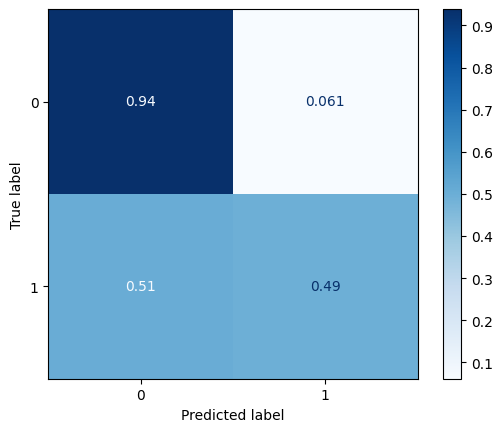

Confusion matrix:
 [[690  45]
 [ 45  44]]
Percentage classification error obtained from validation set: 10.922330097087379%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000
78/78 [==============================] - 1s 2ms/step - loss: 0.2367 - acc: 0.6192
Epoch 2/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1608 - acc: 0.8875
Epoch 3/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1201 - acc: 0.8907
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1026 - acc: 0.8907
Epoch 5/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0939 - acc: 0.8911
Epoch 6/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0886 - acc: 0.8944
Epoch 7/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0849 - acc: 0.8992
Epoch 8/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0820 - acc: 0.8988
Epoch 9/1000
78/78 

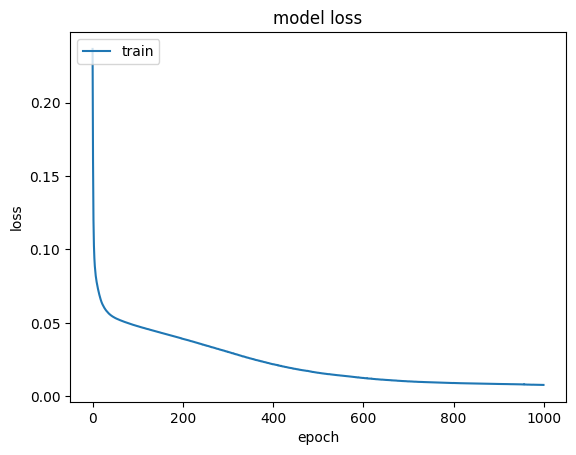

26/26 [==============================] - 0s 2ms/step


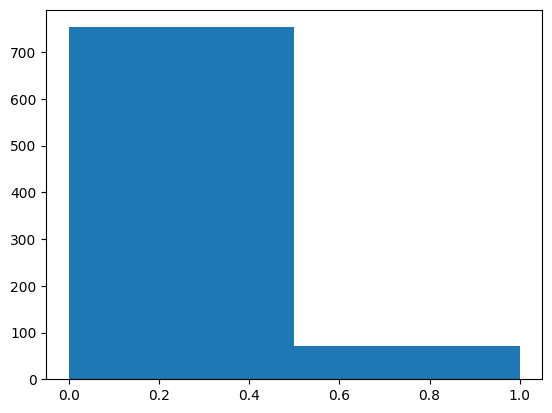

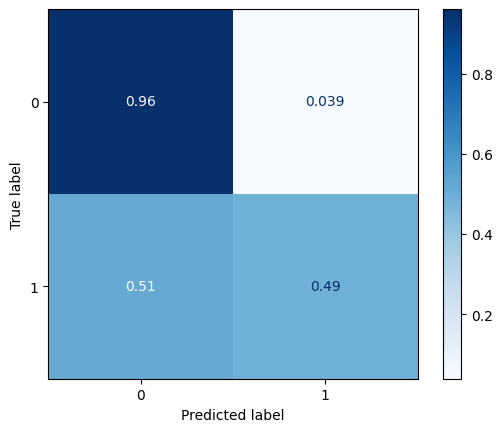

Confusion matrix:
 [[709  29]
 [ 44  42]]
Percentage classification error obtained from validation set: 8.859223300970873%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000
78/78 [==============================] - 1s 2ms/step - loss: 0.1647 - acc: 0.8633
Epoch 2/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1136 - acc: 0.8916
Epoch 3/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0990 - acc: 0.8916
Epoch 4/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0915 - acc: 0.8912
Epoch 5/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0858 - acc: 0.8912
Epoch 6/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0815 - acc: 0.8916
Epoch 7/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0784 - acc: 0.8924
Epoch 8/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.0759 - acc: 0.8944
Epoch 9/1000
78/78 [

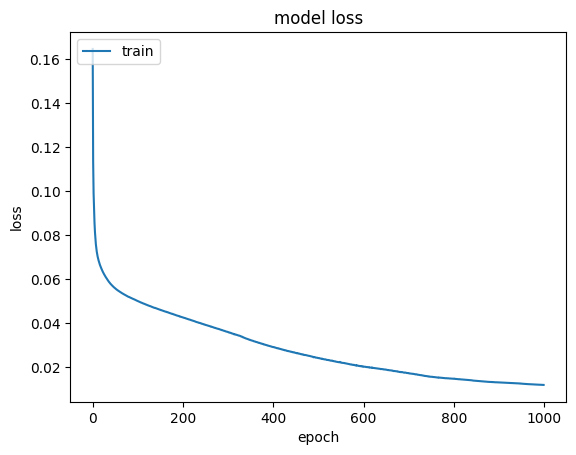

26/26 [==============================] - 0s 2ms/step


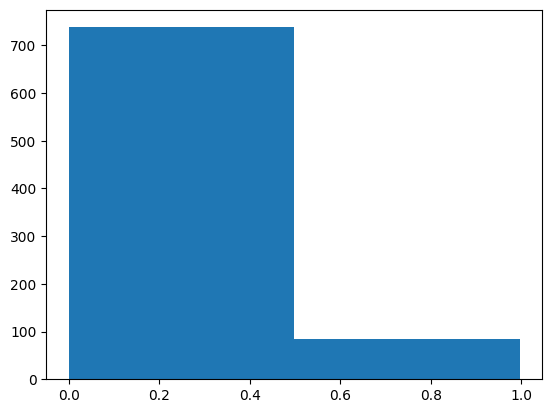

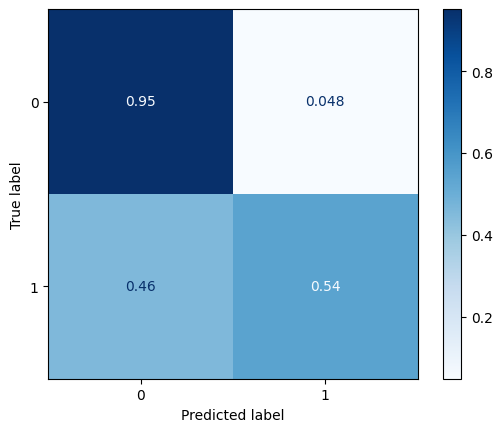

Confusion matrix:
 [[698  35]
 [ 41  49]]
Percentage classification error obtained from validation set: 9.234507897934387%

Results of cross validation:
------------------------------------------------------------------------
Percentage classification error obtained from validation set per fold
------------------------------------------------------------------------
> Fold 1 - 9.83009708737864%
------------------------------------------------------------------------
> Fold 2 - 10.922330097087379%
------------------------------------------------------------------------
> Fold 3 - 8.859223300970873%
------------------------------------------------------------------------
> Fold 4 - 9.234507897934387%
------------------------------------------------------------------------
Mean percentage classification error obtained from cross validation:
> 9.711539595842819% (+- 0.7800756091586509)
------------------------------------------------------------------------


In [12]:
learning_rate = 0.01  # learning rate
momentum = 0.05       # momentum
nn = [20, 100, 25, 5, 1]  # number of neurons for each layer

fold_no = 1

cv_percentage_classification_errors = list()

# 4-fold cross-validation
kf = KFold(n_splits=4, shuffle=True)
for train, validation in kf.split(X_train):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    model = kr.Sequential()

    l1 = model.add(kr.layers.Dense(nn[1], activation='relu'))
    l2 = model.add(kr.layers.Dense(nn[2], activation='relu'))
    l3 = model.add(kr.layers.Dense(nn[3], activation='relu'))
    l4 = model.add(kr.layers.Dense(nn[4], activation='sigmoid'))

    model.compile(loss='mse', optimizer=kr.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), metrics=['acc'])

    history = model.fit(X_train[train], y_train[train], epochs=1000)

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    # Generate predictions
    y_pred = model.predict(X_train[validation])
    #print(y_train[validation], y_pred)
    plt.hist(y_pred, bins=2)

    # Use a threshold to select the probabilities that will determine class 0 or 1
    threshold = 0.5
    y_pred = np.where(y_pred > threshold, 1,0)

    # Evaluate by means of a confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_train[validation], y_pred,
                                                    cmap=plt.cm.Blues,
                                                    normalize='true')
    plt.show()

    cm = confusion_matrix(y_train[validation], y_pred)
    print('Confusion matrix:\n', cm)

    # Calculate the percentage classification error obtained from validation test
    percentage_classification_error = 100 * ((cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))
    print(f'Percentage classification error obtained from validation set: {percentage_classification_error}%')

    cv_percentage_classification_errors.append(percentage_classification_error)

    # Increase fold number
    fold_no = fold_no + 1

print('\nResults of cross validation:')
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Percentage classification error obtained from validation set per fold')
for i in range(0, len(cv_percentage_classification_errors)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - {cv_percentage_classification_errors[i]}%')
print('------------------------------------------------------------------------')
# Calculate the mean percentage classification error obtained from cross-validation
print('Mean percentage classification error obtained from cross validation:')
print(f'> {np.mean(cv_percentage_classification_errors)}% (+- {np.std(cv_percentage_classification_errors)})')
print('------------------------------------------------------------------------')

**Training using Keras**

Epoch 1/1000
103/103 [==============================] - 1s 2ms/step - loss: 0.2223 - acc: 0.7150
Epoch 2/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.1499 - acc: 0.8904
Epoch 3/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.1136 - acc: 0.8920
Epoch 4/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0987 - acc: 0.8929
Epoch 5/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0914 - acc: 0.8935
Epoch 6/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0870 - acc: 0.8974
Epoch 7/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0839 - acc: 0.8995
Epoch 8/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0816 - acc: 0.9008
Epoch 9/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0798 - acc: 0.9047
Epoch 10/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0783 - acc: 0.9032
Epoch 11/1000
103/103 [======

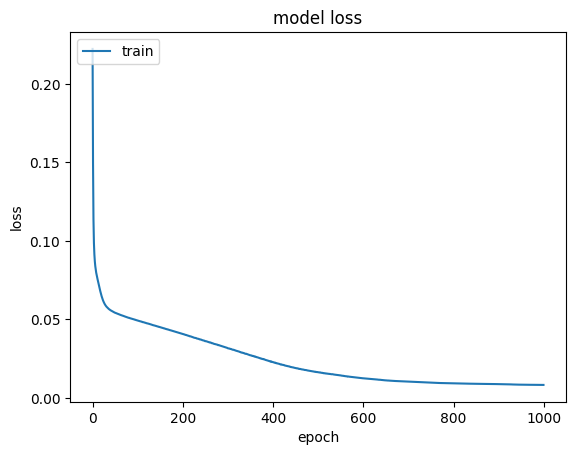

In [13]:
learning_rate = 0.01  # learning rate
momentum = 0.05       # momentum
nn = [20, 100, 25, 5, 1]  # number of neurons for each layer

model = kr.Sequential()

l1 = model.add(kr.layers.Dense(nn[1], activation='relu'))
l2 = model.add(kr.layers.Dense(nn[2], activation='relu'))
l3 = model.add(kr.layers.Dense(nn[3], activation='relu'))
l4 = model.add(kr.layers.Dense(nn[4], activation='sigmoid'))

model.compile(loss='mse', optimizer=kr.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), metrics=['acc'])

history = model.fit(X_train, y_train, epochs=1000)

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


**Test || Keras**

26/26 [==============================] - 0s 2ms/step


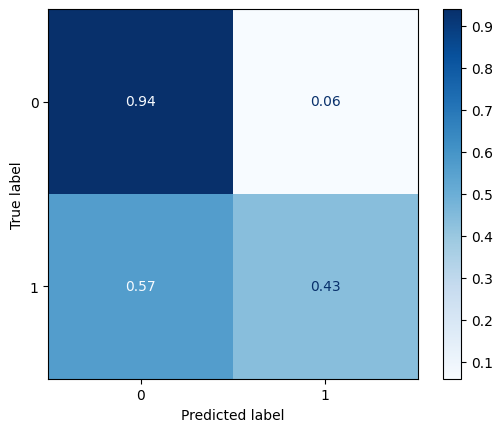

Confusion matrix:
 [[688  44]
 [ 52  40]]
Percentage classification error obtained from test set: 11.650485436893204%


In [14]:
# Generate predictions
y_pred = model.predict(X_test)

# Use a threshold to select the probabilities that will determine class 0 or 1
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1,0)

# Evaluate by means of a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
																								cmap=plt.cm.Blues,
																								normalize='true')
plt.show()

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# Calculate the percentage classification error obtained from test set
percentage_classification_error = 100 * ((cm[0][1] + cm[1][0]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0]))
print(f'Percentage classification error obtained from test set: {percentage_classification_error}%')

True Positives (TP): 42 instances were correctly classified as positive.

False Positives (FP): 47 instances were incorrectly classified as positive.

True Negatives (TN): 685 instances were correctly classified as negative.

False Negatives (FN): 50 instances were incorrectly classified as negative.

Percentage Classification Error: 11.77%


This indicates that approximately 11.77% of instances in the test set were misclassified.

Summary:

The confusion matrix provides a detailed breakdown of true positives, false positives, true negatives, and false negatives. The model has a percentage classification error of 11.77%, suggesting that around 11.77% of instances in the test set were misclassified. Further analysis or exploration of other evaluation metrics may be beneficial to gain a comprehensive understanding of the model's performance.

In [15]:
y_pred = np.concatenate(y_pred, axis=0)

bank_bp_results = { 'real_value': y_test,
                    'prediction': y_pred}

df = pd.DataFrame(bank_bp_results)

df.to_csv('bank_bp_results.csv')

In [16]:
weights = model.get_weights()
np.savetxt('bank_bp_model_weights.csv', weights, fmt='%s', delimiter=',')

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:1533: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("bank_bp_model.json", "w") as json_file:
    json_file.write(model_json)